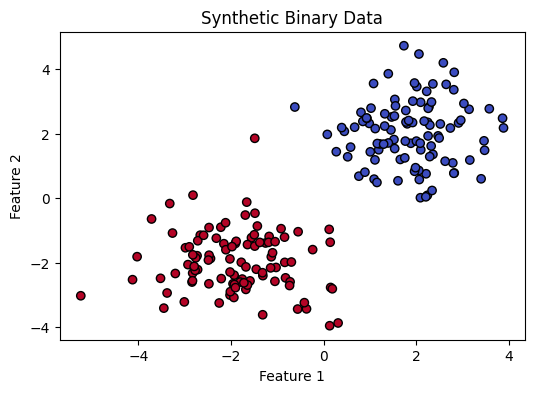

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)


def generate_data(n_samples=200):
    X0 = np.random.randn(n_samples // 2, 2) + np.array([2, 2])
    Y0 = np.zeros((n_samples // 2, 1))

    X1 = np.random.randn(n_samples // 2, 2) + np.array([-2, -2])
    Y1 = np.ones((n_samples // 2, 1))

    X = np.vstack((X0, X1))
    Y = np.vstack((Y0, Y1))

    indices = np.random.permutation(n_samples)
    return X[indices], Y[indices]


X, Y = generate_data()

plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=Y.flatten(), cmap="coolwarm", edgecolors="k")
plt.title("Synthetic Binary Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### The B-Spline KAN Class

In [3]:
import numpy as np
import matplotlib.pyplot as plt


class BSplineKAN:
    def __init__(self, grid_min=-8.0, grid_max=8.0, G=8, k=3):
        """
        G: Number of grid intervals
        k: Degree of the B-splines (3 = cubic splines)
        """
        self.k = k
        self.G = G

        # 1. Create the Knot Grid
        # We need k extra knots on the left and right for the boundary splines
        step = (grid_max - grid_min) / G
        self.knots = np.arange(grid_min - k * step, grid_max + (k + 1) * step, step)

        # 2. Number of learnable parameters (coefficients) per edge
        self.num_c = G + k

        # 3. Initialize learnable coefficients for Edge 1 and Edge 2 randomly
        self.c1 = np.random.randn(self.num_c, 1) * 0.1
        self.c2 = np.random.randn(self.num_c, 1) * 0.1

    def _cox_de_boor(self, x, k, i):

        if k == 0:
            # Base case: 1 if x is in the knot interval, else 0
            return ((x >= self.knots[i]) & (x < self.knots[i + 1])).astype(float)
        else:
            # Recursive case
            den1 = self.knots[i + k] - self.knots[i]
            term1 = 0
            if den1 > 0:
                term1 = ((x - self.knots[i]) / den1) * self._cox_de_boor(x, k - 1, i)

            den2 = self.knots[i + k + 1] - self.knots[i + 1]
            term2 = 0
            if den2 > 0:
                term2 = ((self.knots[i + k + 1] - x) / den2) * self._cox_de_boor(
                    x, k - 1, i + 1
                )

            return term1 + term2

    def get_basis_matrix(self, X):
        """
        Evaluates all B-spline basis functions for the input X.
        Returns a matrix B of shape (m, num_c)
        """
        m = X.shape[0]
        B = np.zeros((m, self.num_c))
        for i in range(self.num_c):
            B[:, i : i + 1] = self._cox_de_boor(X, self.k, i)
        return B

    def forward(self, X):
        self.x1 = X[:, 0:1]
        self.x2 = X[:, 1:2]

        # 1. Get B-spline basis evaluations for the data
        self.B1 = self.get_basis_matrix(self.x1)
        self.B2 = self.get_basis_matrix(self.x2)

        # 2. The edge function is the dot product of Basis * Coefficients
        # phi(x) = sum(c_i * B_i(x))
        self.phi1 = np.dot(self.B1, self.c1)
        self.phi2 = np.dot(self.B2, self.c2)

        # 3. The Node simply sums the edges
        self.Z = self.phi1 + self.phi2

        # 4. Squashing using CLIPPING (No Sigmoid)
        self.epsilon = 1e-15
        self.A = np.clip(self.Z, self.epsilon, 1 - self.epsilon)

        return self.A

    def backward(self, Y, learning_rate):
        m = Y.shape[0]

        # 1. Gradient of BCE Loss
        dA = -(np.divide(Y, self.A) - np.divide(1 - Y, 1 - self.A))

        # 2. Gradient through the Clip operation
        # The derivative is 1 inside the clipped range, and 0 outside.
        dZ = dA * ((self.Z > self.epsilon) & (self.Z < 1 - self.epsilon)).astype(float)

        # 3. Gradients for the coefficients (Chain Rule: dZ/dc = B)
        dc1 = (1 / m) * np.dot(self.B1.T, dZ)
        dc2 = (1 / m) * np.dot(self.B2.T, dZ)

        # 4. Update coefficients
        self.c1 -= learning_rate * dc1
        self.c2 -= learning_rate * dc2

    def compute_loss(self, Y):
        return -np.mean(Y * np.log(self.A) + (1 - Y) * np.log(1 - self.A))

    def predict(self, X):
        A = self.forward(X)
        return (A > 0.5).astype(int)

### Training the B-Spline KAN

In [4]:
# Initialize Model
kan_spline = BSplineKAN(grid_min=-8.0, grid_max=8.0, G=8, k=3)

epochs = 1000
# Smaller learning rate because B-splines can be highly sensitive
lr = 0.05

loss_hist = []
acc_hist = []

print("--- Training B-Spline KAN (Clipped Output) ---")
for i in range(epochs):
    # Forward Pass
    kan_spline.forward(X)

    # Metrics
    loss = kan_spline.compute_loss(Y)
    preds = kan_spline.predict(X)
    acc = np.mean(Y == preds)

    loss_hist.append(loss)
    acc_hist.append(acc)

    # Backward Pass
    kan_spline.backward(Y, learning_rate=lr)

    if i % 100 == 0:
        print(f"Epoch {i:3d} | Loss: {loss:.4f} | Acc: {acc:.4f}")

print(f"Final Epoch | Loss: {loss_hist[-1]:.4f} | Acc: {acc_hist[-1]:.4f}")

--- Training B-Spline KAN (Clipped Output) ---
Epoch   0 | Loss: 14.0352 | Acc: 0.5000
Epoch 100 | Loss: 0.0121 | Acc: 0.9950
Epoch 200 | Loss: 0.0069 | Acc: 0.9950
Epoch 300 | Loss: 0.0048 | Acc: 0.9950
Epoch 400 | Loss: 0.0039 | Acc: 0.9950
Epoch 500 | Loss: 0.0034 | Acc: 1.0000
Epoch 600 | Loss: 0.0030 | Acc: 1.0000
Epoch 700 | Loss: 0.0026 | Acc: 1.0000
Epoch 800 | Loss: 0.0023 | Acc: 1.0000
Epoch 900 | Loss: 0.0020 | Acc: 1.0000
Final Epoch | Loss: 0.0018 | Acc: 1.0000


### Visualizing the Learned Splines and Boundary

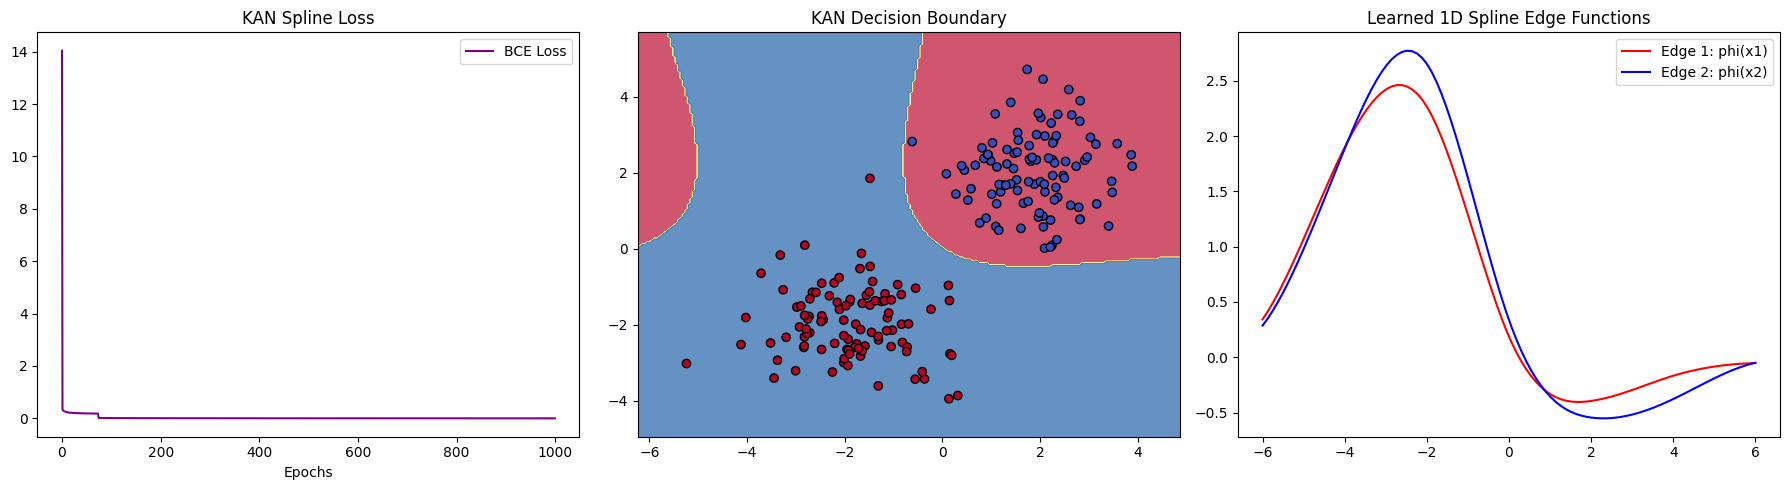

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Plot Loss
axes[0].plot(loss_hist, color="purple", label="BCE Loss")
axes[0].set_title("KAN Spline Loss")
axes[0].set_xlabel("Epochs")
axes[0].legend()

# 2. Plot Decision Boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

Z_grid = kan_spline.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

axes[1].contourf(xx, yy, Z_grid, cmap=plt.cm.Spectral, alpha=0.8)
axes[1].scatter(X[:, 0], X[:, 1], c=Y.flatten(), cmap=plt.cm.coolwarm, edgecolors="k")
axes[1].set_title("KAN Decision Boundary")

# 3. Plot the Learned Edge Functions phi(x)
test_x = np.linspace(-6, 6, 100).reshape(-1, 1)
test_B = kan_spline.get_basis_matrix(test_x)
phi1_learned = np.dot(test_B, kan_spline.c1)
phi2_learned = np.dot(test_B, kan_spline.c2)

axes[2].plot(test_x, phi1_learned, label="Edge 1: phi(x1)", color="red")
axes[2].plot(test_x, phi2_learned, label="Edge 2: phi(x2)", color="blue")
axes[2].set_title("Learned 1D Spline Edge Functions")
axes[2].legend()

plt.tight_layout()
plt.show()

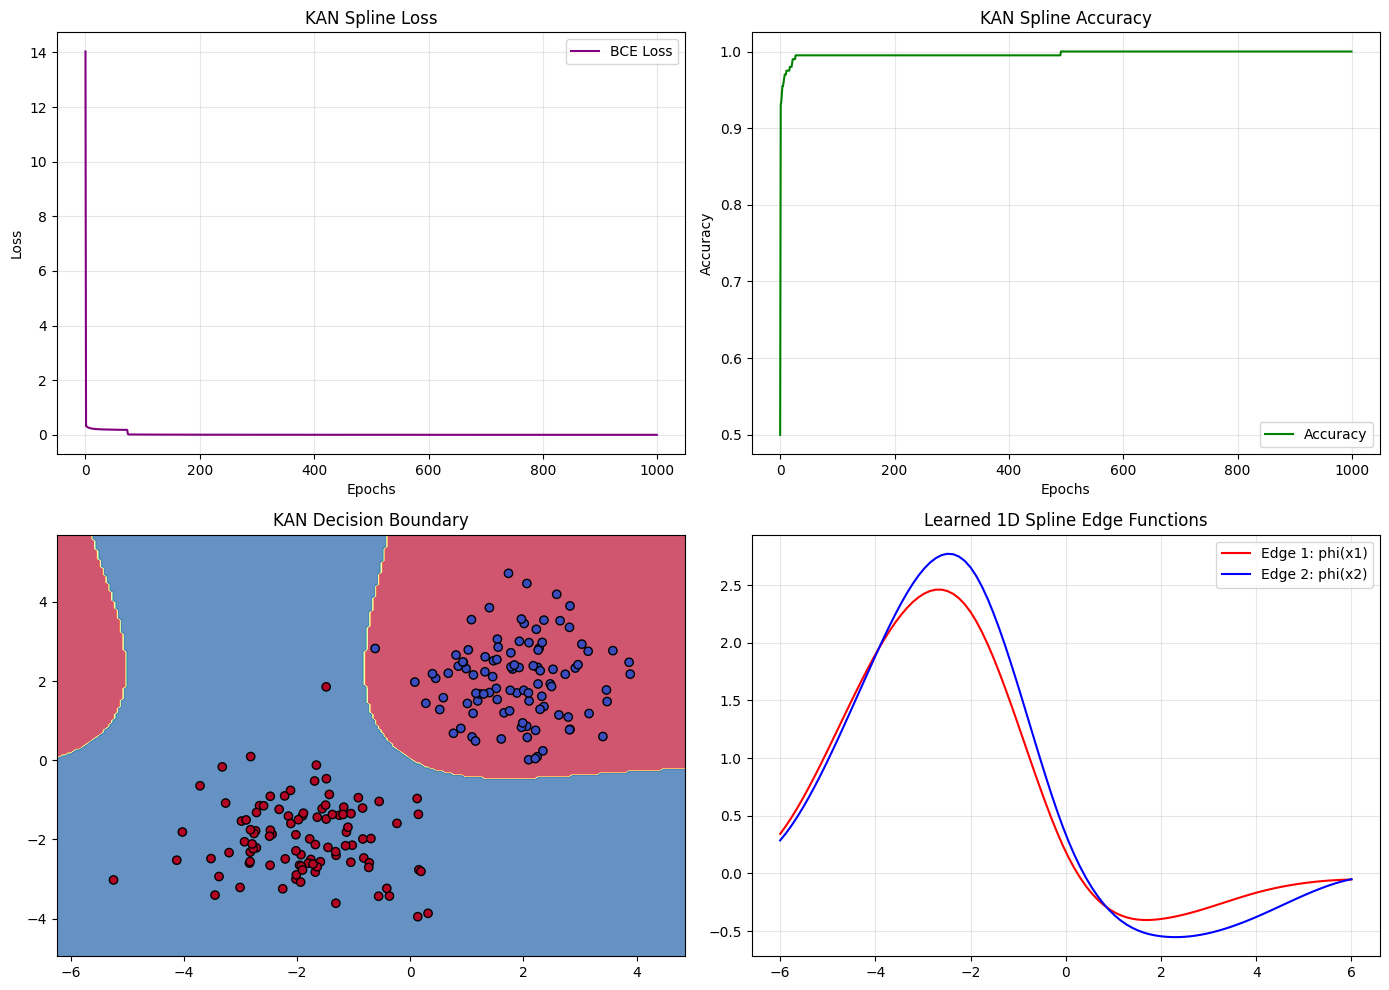

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# 1. Plot Loss
axes[0].plot(loss_hist, color="purple", label="BCE Loss")
axes[0].set_title("KAN Spline Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# 2. Plot Accuracy (NEW ADDITION)
axes[1].plot(acc_hist, color="green", label="Accuracy")
axes[1].set_title("KAN Spline Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# 3. Plot Decision Boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

Z_grid = kan_spline.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

axes[2].contourf(xx, yy, Z_grid, cmap=plt.cm.Spectral, alpha=0.8)
axes[2].scatter(X[:, 0], X[:, 1], c=Y.flatten(), cmap=plt.cm.coolwarm, edgecolors="k")
axes[2].set_title("KAN Decision Boundary")

# 4. Plot the Learned Edge Functions phi(x)
test_x = np.linspace(-6, 6, 100).reshape(-1, 1)
test_B = kan_spline.get_basis_matrix(test_x)
phi1_learned = np.dot(test_B, kan_spline.c1)
phi2_learned = np.dot(test_B, kan_spline.c2)

axes[3].plot(test_x, phi1_learned, label="Edge 1: phi(x1)", color="red")
axes[3].plot(test_x, phi2_learned, label="Edge 2: phi(x2)", color="blue")
axes[3].set_title("Learned 1D Spline Edge Functions")
axes[3].grid(True, alpha=0.3)
axes[3].legend()

plt.tight_layout()
plt.show()